# Analyse d'ensemble





## Quand est-ce que l'on fait de l'analyse d'ensemble ?


On a des données.

Chaque données est une séquence. Par exemple une séquence composée de points 3d.  


Ses séquences sont souvent de longueur variable (comme des phrases).

L'ordre dans cette séquence n'a aucune importance (comme dans un ensemble mathématique).

Par contre la répétition d'un élément dans la séquence peut avoir une importance (contrairement à un ensemble mathématique).


On appélera "ensemble" une telle séquence.


Notons bien que notre jeu de donnée est composé de plusieur ensembles.


Je vous invite à regarder tout de suite le "jeu de données mobilier" pour voir un exemple concret.  


In [ ]:
%reset -f

In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time
from tensorflow.keras import layers
from IPython.display import clear_output
import pandas as pd
import timeit

## Rappel sur l'attention

### Dessin

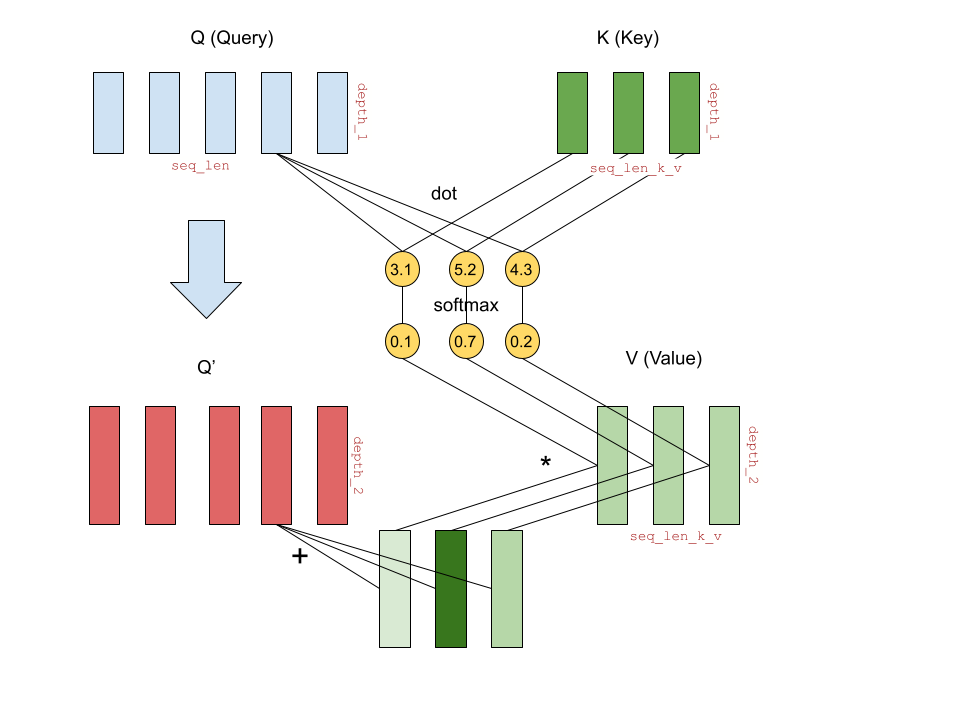

Si on suppose que les vecteurs sont les lignes des matrices $Q,K,V$,  la formule compléte (avec normalisation) est:
$$
Q' = \text{softmax}\left(\frac{QK^T}{\sqrt{d_1}}\right) V
$$
$d_1$=`depth_1`




### la fonction

In [ ]:
def scaled_dot_product_attention(q,v,k,return_weights=False):
  """
  Args:
      q: query shape == (..., seq_len  ,  depth_1)
      v: value shape == (..., seq_len_vk, depth_2)
      k: key shape   == (..., seq_len_vk, depth_1)

  Returns:
    output, attention_weights
    ouput.shape == (...,seq_len, depth_2)
    attention_weights.shape == (...,seq_len,seq_len_vk)
  """

  # Q@K.T
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_vk)

  # scale matmul_qk
  depth_1 = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(depth_1)

  # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len, seq_len_vk)

  output = tf.matmul(attention_weights, v)  # (..., seq_len, depth_2)

  if return_weights:
    return output, attention_weights
  else:
    return output

### la classe






<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">



In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,return_weights=False,attention_fn=None):
        super().__init__()

        self.num_heads = num_heads
        self.d_model = d_model
        self.return_weights=return_weights
        self.attention_fn=attention_fn

        assert d_model % self.num_heads == 0


        self.head_size = d_model // self.num_heads

        self.wv = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wq = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, head_size).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, head_size)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_size))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q,v,k):
        batch_size = tf.shape(q)[0]
        v = self.wv(v)  # (batch_size, seq_len_vk, d_model)
        k = self.wk(k)  # (batch_size, seq_len_vk, d_model)
        q = self.wq(q)  # (batch_size, seq_len, d_model)

        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_vk, head_size)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_vk, head_size)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, head_size)

        """
        la scaled_dot_product_attention est appliquée sur les différentes têtes.
        Cette fonction agit sur les deux dernières dimensions des tenseurs, qui sont  (seq_len_x, head_size)
        """

        if self.attention_fn is None:
            scaled_attention, attention_weights = scaled_dot_product_attention(q,v, k,True)
        else:
            scaled_attention, attention_weights = self.attention_fn(q,v,k)
        # scaled_attention.shape : (batch_size, num_heads, seq_len_q,  head_size)
        # attention_weights.shape: (batch_size, num_heads, seq_len_vk, seq_len)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, head_size)

        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len, d_model)

        if self.return_weights:
            return output, attention_weights
        else:
            return output

## Deep Set

### Architecture globale

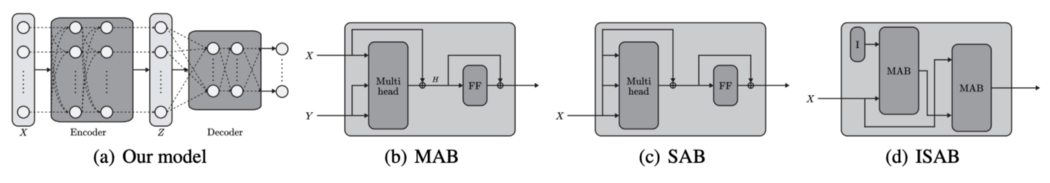

* On note `|X|` pour `layerNormalization(X)`. Rappelons que c'est une normalisation par rapport la moyenne et l'écartype sur la dernière dimension :

         mu_ij = mean(X,axis=-1)
         si_ij = std(X,axis=-1)
        |X|_ijk = (X_ijk-mu_ij) / si_ij


* On note `FF` un réseau Dense qui s'applique sur la dernière dimension des tenseurs. Le plus simple d'entre eux étant:

        FF(X)_ijk = relu ( sum_l  X_ijl W_lk )

### `MAB` : Multihead Attention Block


    def MAB(X, Y):
        #X :  shape (b,n,d)
        #Y :  shape (b,m,d)

        H = |X + mha(X,Y,Y)| # shape `(b,n,d)`

        return |H + FF(H)|   # shape `(b,n,d)`
         

### `SAB` : Set Attention Block

Il permet de traiter une séquence. Mais il est trop couter (n*n produits scalaires).

        SAB(X) = MAB(X,X)


### `ISAB`: Inducing Set Attention Block

Variante pour réduire la dimension des matrices d'attention. C'est un peu comme dans le linformer.

On prend `r<<n`

on tire un vecteur p aléatoirement, mais ensuite il restera fixe
d'un appel à l'autre de ISAB.

    

    def ISAB(X):
        #X shape [b,n,d]

        p  # fixed random (normal law) tensor of shape [1, r, d]

        P = repeat(p, b, axis=0)              # shape [b, r, d]

        H = MAB_1(P,X)                        # shape [b, r, d]

        return MAB_2(X,H)                     # shape [b, n, d]

Ainsi on a calculé 2 matrices d'attentions de taille $r\times n$ et $n\times r$ ce qui est bien plus petit que $n\times n$
        

### `PMA` Pooling by Multihead Attention

Polling signifie tout mélanger. Ici le mélange vient du fait qu'on fait un `MAB` avec un `K=V` constant de dimension temporelle `k` très petite (ex: 8). On ne garde plus sur tout la dimension temporelle de nos données: car on veut inférer une caractéristique globale sur une suite de donnée (ex: est-ce un bruit d'un moteur défectueux).



    def PMA(X)
        #X shape [b, n, d]
        #k : number of seed vectors, très petit (ex: 8)
        s = seed_vectors # fixed random (normal law) tensor of shape [1, k, d]
        S = repeat(s, b, axis=0)  # shape [b, k, d]
        
        return MAB(S, FF(X))   # shape [b, k, d]



### Assemblage

    Encoder:
        Z = SAB o ... o SAB(X) #shape (b,n,d)
    Decoder:
        H= SAB(PMA(Z))    #shape (b,k,d)
        H = Flatten(H)   #shape (b,k*d)
        res = FF(H)      #shape (b,output_dim)

    ou encore mieux: pour aller plus vite on remplace les SAB par des ISAB

### Implémentation

In [ ]:
class FF(tf.keras.layers.Layer):
    """
    FeedForward layers.
    """
    def __init__(self, d):
        super().__init__()
        self.ff_1 = tf.keras.layers.Dense(d, activation='relu')
        self.ff_2 = tf.keras.layers.Dense(d, activation='relu')
        self.ff_3 = tf.keras.layers.Dense(d, activation='relu')

    def call(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
        return self.ff_3(self.ff_2(self.ff_1(x)))


class MultiHeadAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d: int, num_head: int):
        super().__init__()
        self.multihead = MultiHeadAttention(d, num_head)
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, dtype='float32')
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, dtype='float32')
        self.ff = FF(d)

    def call(self, x, y):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
            y: a float tensor with shape [b, r, d].
        Returns:
            a float tensor with shape [b, n, d].
        """

        h = self.layer_norm1(x + self.multihead(x, y, y))
        return self.layer_norm2(h + self.ff(h))



class SetAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d: int, num_head: int):
        super().__init__()
        self.mab = MultiHeadAttentionBlock(d, num_head)

    def call(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
        return self.mab(x, x)


class InducedSetAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d: int, r: int, num_head: int):
        """
        Arguments:
            d: an integer, input dimension.
            r: an integer, number of inducing points.
            num_head: an integer, number of heads.
            ff1, ff2: modules, row-wise feedforward layers.
                It takes a float tensor with shape [b, n, d] and
                returns a float tensor with the same shape.
        """
        super().__init__()
        self.mab1 = MultiHeadAttentionBlock(d, num_head)
        self.mab2 = MultiHeadAttentionBlock(d, num_head)
        self.inducing_points = tf.random.normal(shape=(1, r, d))

    def call(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, n, d].
        """
        b = tf.shape(x)[0]
        p = self.inducing_points
        p = tf.repeat(p, b, axis=0)  # shape [b, r, d]

        h = self.mab1(p, x)  # shape [b, r, d]
        return self.mab2(x, h) # shape [b, n, d]



class PoolingMultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d: int, k: int, num_head: int):
        """
        Arguments:
            d: an integer, input dimension.
            k: an integer, number of seed vectors.
            num_head: an integer, number of heads.
            ff: a module, row-wise feedforward layers.
                It takes a float tensor with shape [b, n, d] and
                returns a float tensor with the same shape.
        """
        super().__init__()
        self.mab = MultiHeadAttentionBlock(d, num_head)
        self.seed_vectors = tf.random.normal(shape=(1, k, d))
        self.ff = FF(d)


    @tf.function
    def call(self, z):
        """
        Arguments:
            z: a float tensor with shape [b, n, d].
        Returns:
            a float tensor with shape [b, k, d]
        """
        b = tf.shape(z)[0]
        s = tf.repeat(self.seed_vectors, b, axis=0)  # shape [b, k, d]
        return self.mab(s, self.ff(z)) # shape [b, k, d]



class Encoder(tf.keras.layers.Layer):
    def __init__(self, d, r, num_head,num_blocks):
        super().__init__()

        # Embedding part
        self.ff = tf.keras.layers.Dense(d)#, activation='relu'

        # Encoding part
        self.blocks=[]
        for _ in range(num_blocks):
            self.blocks.append(InducedSetAttentionBlock(d, r, num_head))

    def call(self, x):
        y=self.ff(x)

        for block in self.blocks:
            y=block(y)

        return y #(b,n,d)



class Decoder(tf.keras.layers.Layer):
    def __init__(self, out_dim, d, num_head, k):
        super().__init__()

        self.PMA = PoolingMultiHeadAttention(d, k, num_head)
        self.SAB = SetAttentionBlock(d, num_head)
        self.output_mapper = tf.keras.layers.Dense(out_dim)
        self.k, self.d = k, d

    def call(self, x):
        pooled=self.PMA(x)       #(b,k,d)
        decoded_vec = self.SAB(pooled) #(b,k,d)
        decoded_vec = tf.reshape(decoded_vec, [-1, self.k * self.d])  #(b,kd)
        return self.output_mapper(decoded_vec) #tf.reshape(self.output_mapper(decoded_vec), (tf.shape(decoded_vec)[0],))


class SetTransformer(tf.keras.Model):
    def __init__(self, encoder_d, r, encoder_num_head, out_dim, decoder_d, decoder_num_head, k,num_blocks):
        super().__init__()
        self.basic_encoder = Encoder(d=encoder_d, r=r, num_head=encoder_num_head,num_blocks=num_blocks)
        self.basic_decoder = Decoder(out_dim=out_dim, d=decoder_d, num_head=decoder_num_head, k=k)

    def call(self, x):
        enc_output = self.basic_encoder(x)  # (batch_size, set_len, d_model)
        res= self.basic_decoder(enc_output)
        return res



def make_deepset(dim_out):
    return SetTransformer(encoder_d=16,
                          r=4,
                          encoder_num_head=2,
                          out_dim=dim_out,
                          decoder_d=16,
                          decoder_num_head=2,
                          k=2,
                          num_blocks=2,
                        )

def test():
    dim_out=2
    X=tf.ones([1,5,3])
    model=make_deepset(dim_out)
    Y=model(X)
    print(Y.shape)
    assert Y.shape[1]==dim_out
test()

## Modèle à base de MaxPooling

Une autre technique pour construire des modèles invariant par permuation d'une entrée, et d'utiliser le maxPooling

### MaxPoolingNet

Une architecture maison, toute bête.

In [ ]:
def block(x,units,activation):
    h=layers.Dense(units,activation=activation)(x)
    return layers.LayerNormalization()(x+h)

In [ ]:
def make_maxPoolingNet(dim_in,dim_out):

    inputs = keras.Input(shape=(None, dim_in)) #(b,n,dim_in)
    activation="relu"

    dim_model=512
    x=layers.Dense(dim_model)(inputs)#(b,n,512)
    for _ in range(2):
        x=block(x,dim_model,activation)#(b,n,512)


    """
    En mode tensorflow:
    x = tf.reduce_max(x,axis=1)
    """
    x = layers.GlobalMaxPooling1D()(x) #(b,512)

    dim_model_after=32
    x=layers.Dense(dim_model_after)(x) #(b,32)

    for _ in range(3):
        x=block(x,dim_model_after,activation)#(b,32)

    outputs = layers.Dense(dim_out)(x)#(b,dim_out)

    return keras.Model(inputs=inputs, outputs=outputs)


def test():
    n=12
    dim_in=5
    dim_out=2
    model=make_maxPoolingNet(dim_in,dim_out)
    X=tf.random.uniform([1,n,dim_in])
    res=model(X)
    print(res.shape)
test()

### PointNet

Spécialement conçu pour l'annalyse d'ensemble de point représentant des positions. Ci-dessous, ces points sont dans $\mathbb R^3$.

Notons que le nombre de point $n$ peut varier d'un batch à l'autre.

[Article](https://arxiv.org/pdf/1612.00593.pdf)

[Tuto keras](https://keras.io/examples/vision/pointnet/)

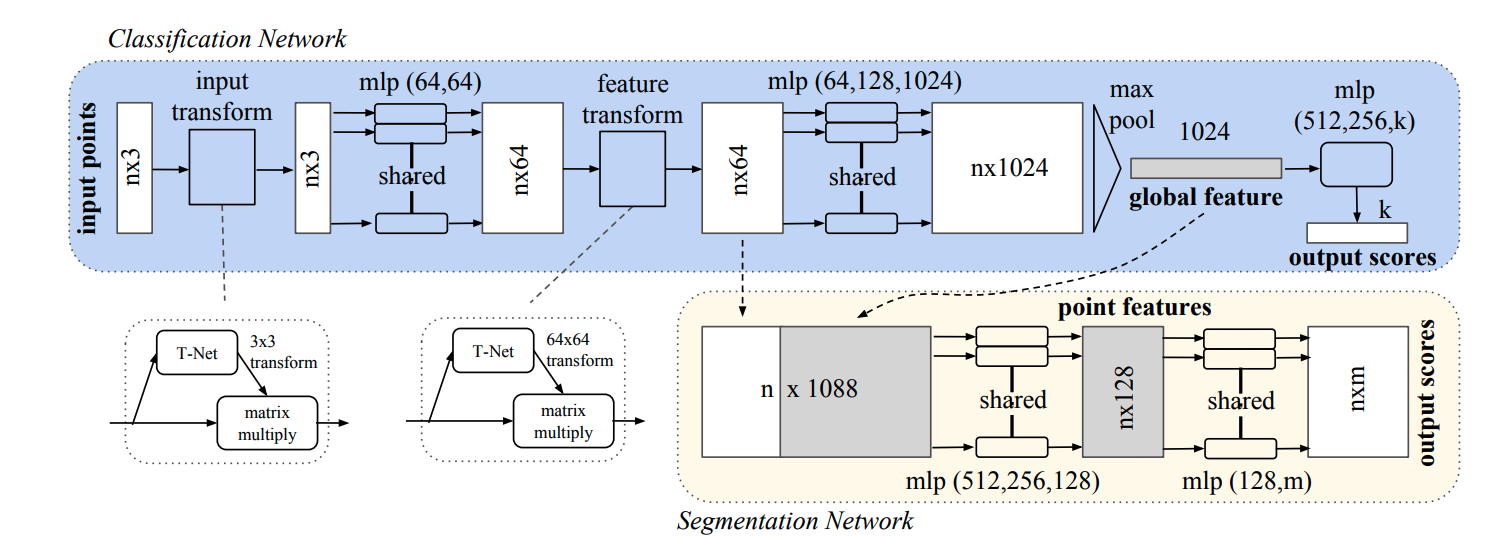

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    #dans le tuto keras ils utilisent ça, mais ça donne n'importe quoi lors de la phase d'inférence
    #x = layers.BatchNormalization(momentum=0.0)(x)
    x = layers.LayerNormalization()(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    #dans le tuto keras ils utilisent ça, mais ça donne n'importe quoi lors de la phase d'inférence
    #x = layers.BatchNormalization(momentum=0.0)(x)
    x = layers.LayerNormalization()(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
def tnet(inputs, num_features,use_orthogonal_regularize):

    assert inputs.shape[2]==num_features

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    if use_orthogonal_regularize:
        reg = OrthogonalRegularizer(num_features)
    else:
        reg = None

    #inputs.shape = (b,n,num_features)
    x = conv_bn(inputs, 32) #(b,n,32)
    x = conv_bn(x, 64) #(b,n,64)
    x = conv_bn(x, 512) #(b,n,512)
    x = layers.GlobalMaxPooling1D()(x) #(b,512)
    x = dense_bn(x, 256) #(b,256)
    x = dense_bn(x, 128) #(b,128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x) #(b,num_features*num_features)
    feat_T = layers.Reshape((num_features, num_features))(x) #(b,num_features,num_features)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T]) #(b,n,num_features)

def test():
    n=12
    num_features=5
    inputs=layers.Input([n,num_features])
    res=tnet(inputs,num_features,True)
    print(res.shape)
test()

In [ ]:
def make_point_net(dim_in,dim_out,use_orthogonal_regularize):

    inputs = keras.Input(shape=(None, dim_in))

    x = tnet(inputs, dim_in,use_orthogonal_regularize)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32,use_orthogonal_regularize)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)


    outputs = layers.Dense(dim_out)(x)

    return keras.Model(inputs=inputs, outputs=outputs)


def test():
    n=12
    dim_in=5
    dim_out=2
    model=make_point_net(dim_in,dim_out,False)
    X=tf.random.uniform([1,n,dim_in])
    res=model(X)
    print(res.shape)
test()

### Et quand il faut aussi une prédiction par point

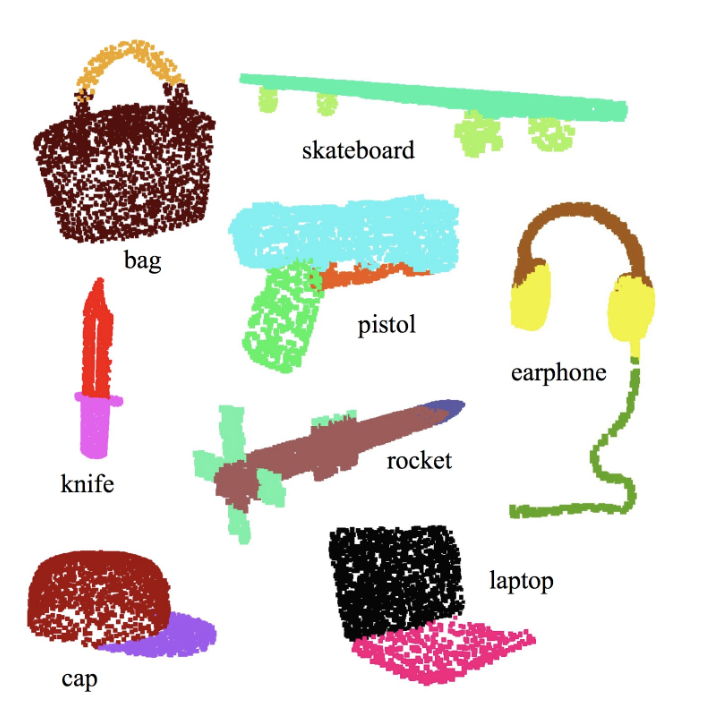

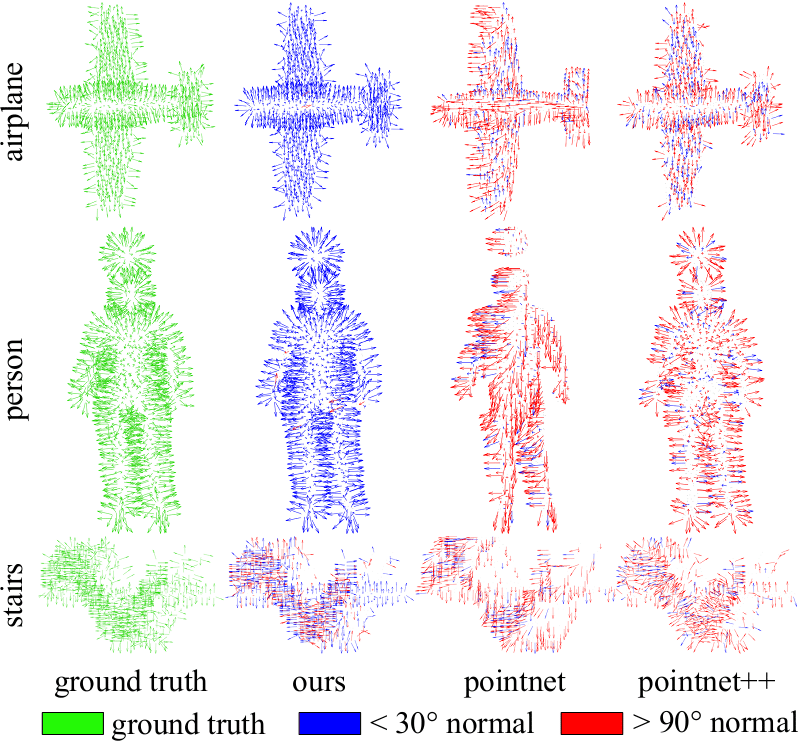

Il font apparemment beaucoup plus mieux que le PointNet dans [cet article](https://arxiv.org/pdf/1904.07601.pdf)

## Modèles classiques

### Conv Net

In [ ]:
class ConvNet(tf.keras.Model):

    def __init__(self,dim_out,filters=64,nb_layers=3):
        super().__init__()

        self.sub=[]
        for _ in range(nb_layers):
            self.sub.append(keras.layers.Conv1D(filters=filters, kernel_size=3, padding="same"))
            self.sub.append(keras.layers.BatchNormalization())
            self.sub.append(keras.layers.ReLU())

        self.pooling = keras.layers.GlobalAveragePooling1D()

        self.last_layer=keras.layers.Dense(dim_out)

    def call(self,X):

        for layer in self.sub:
            X=layer(X)

        X=self.pooling(X)

        return self.last_layer(X)


model=ConvNet(2)
model(tf.random.uniform([1,10,5]))

### Dense

In [ ]:
def makeDense(dim_out):
    return tf.keras.Sequential([
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dense(dim_out),
                           ])

model=makeDense(3)
model(tf.random.uniform([1,20,2])).shape

## L'agent

### Changer le learning rate

On récupère la formule de  [cet article](https://arxiv.org/abs/1706.03762)

$$
lr = \mathtt{d\_model}^{-\frac 12}\min(\mathtt{step}^{-\frac 12},\mathtt{step}*\mathtt{warm\_up}^{-\frac 32})
$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
      super().__init__()

      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)

      self.warmup_steps = warmup_steps

  def __call__(self, step):
      arg1 = tf.math.rsqrt(step) # =step**(-1/2)
      arg2 = step * (self.warmup_steps ** -1.5)

      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
customSchedule=CustomSchedule(32)
steps=tf.cast(tf.range(20_000),tf.float32)

plt.plot(steps,customSchedule(steps));

### Loss et accuracy

Voici un score pour la regression: le R2

In [ ]:
y_true=tf.ones([1,5,2])
y_pred=tf.random.uniform([1,5,2])

In [ ]:
def R_squared(y, y_pred):
    residual = tf.reduce_sum((y - y_pred)**2)
    total = tf.reduce_sum((y - tf.reduce_mean(y))**2)
    return 1.0 -residual / (total+1e-6)

In [ ]:
R_squared(y_true,y_true),R_squared(y_true,y_pred)

In [ ]:
def R_abs(y, y_pred):
    residual = tf.reduce_sum(tf.abs(y - y_pred))
    total = tf.reduce_sum(tf.abs(y - tf.reduce_mean(y)))
    return tf.clip_by_value(1.0 - residual / (total+1e-6),-2,1)

In [ ]:
R_abs(y_true,y_true),R_abs(y_true,y_pred)

### loss et metrique pour la classification

In [ ]:
y_true=tf.constant([ 0,    0,    0,    1   ])
y_pred=tf.constant([[10.3,0.1],[7.5,-2.1],[4.3,0.7],[3.6,8.3]])

In [ ]:
sparse_categorical_crossentropy=lambda y_true, y_pred: tf.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))
print(sparse_categorical_crossentropy(y_true,y_pred))
print(sparse_categorical_crossentropy(y_true,-y_pred))

In [ ]:
sparse_categorical_accuracy=lambda y_true, y_pred: tf.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(y_true,y_pred))
print(sparse_categorical_accuracy(y_true,y_pred))
print(sparse_categorical_accuracy(y_true,-y_pred))

***Attention:*** Ces fonctions peuvent aussi être appelé via des objets, mais elles ont alors un comportement bizarre: elles moyennent tous leurs résulat. Observez:

In [ ]:
accuracy_fn2=tf.keras.metrics.SparseCategoricalAccuracy()
print(accuracy_fn2(y_true,-y_pred))

print(accuracy_fn2(y_true,y_pred))
print(accuracy_fn2(y_true,y_pred))

***A vous:*** Pourquoi n'y a-t-il pas l'option `from_logits` pour la `sparse_categorical_accuracy` ? Si vous ne trouvez pas, c'est bien expliqué dans l'aide.

### Trainer

In [ ]:
class Trainer:

    def __init__(self,X,Y,augmentation_fn,model,classification:bool,lr_schedule=False,verbose=True,batch_size=32):

        self.model=model
        self.verbose=verbose
        self.augmentation_fn=augmentation_fn

        #un dictionnaire de 3 dataSet: train,val,test
        self.ds={}
        l=len(X)

        full_dataset=tf.data.Dataset.from_tensor_slices((X,Y))
        train_size = int(0.7 * l)
        val_size = int(0.15 * l)
        test_size = int(0.15 * l)

        self.ds["train"]  = full_dataset.take(train_size)
        self.ds["val"] = full_dataset.skip(train_size).take(val_size)
        self.ds["test"] = full_dataset.skip(train_size+val_size).take(test_size)

        def finish_one_ds(ds):
            ds=ds.shuffle(10_000).batch(batch_size)
            return ds

        for key in ["train","val","test"]:
            self.ds[key]=finish_one_ds(self.ds[key])

        if classification:
            self.loss_fn=sparse_categorical_crossentropy
            self.acc_fn=sparse_categorical_accuracy
        else:
            self.loss_fn=lambda a,b:tf.reduce_mean((a-b)**2)
            self.acc_fn=R_abs


        self.train_losses = []
        self.val_losses = []

        self.val_acc=[]

        self.val_step_ind=[]

        self.step=-1
        self.epoch=-1
        self.best_weights=None

        if lr_schedule:
            learning_rate=CustomSchedule(32)
        else:
            learning_rate=1e-3

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)


    @tf.function
    def train_step(self,x,y):

        if self.augmentation_fn is not None:
            x=self.augmentation_fn(x)

        with tf.GradientTape() as tape:
            pred = self.model(x,training=True)
            loss = self.loss_fn(y,pred)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return loss


    def train(self, minutes):

        start = time.time()

        try:
            OK=True
            while OK:
                self.epoch+=1

                for x,y in self.ds["train"]:
                    self.step+=1

                    loss = self.train_step(x,y).numpy()
                    self.train_losses.append(loss)

                    OK=time.time() - start < minutes * 60
                    #on s'arrête au milieu d'une période si le temps est fini
                    if not OK:
                        break

                self.validation()

        except KeyboardInterrupt:
            pass

        self.validation()
        print(f"nombre d'époque réalisée: {self.epoch}")

    @tf.function
    def val_test_step(self,x,y):
        pred = self.model(x,training=False)
        val_loss = self.loss_fn(y,pred)
        val_acc = self.acc_fn(y,pred)
        return val_loss,val_acc


    def val_test_steps(self,key):
        los,acs=[],[]
        for x,y in self.ds[key]:
            lo,ac=self.val_test_step(x,y)
            los.append(lo.numpy())
            acs.append(ac.numpy())
        return np.mean(los),np.mean(acs)


    def validation(self):

        val_loss,val_acc=self.val_test_steps("val")

        self.val_losses.append(val_loss)
        self.val_acc.append(val_acc)

        self.val_step_ind.append(self.step)

        if len(self.val_losses)>1 and val_loss<=max(self.val_losses):
            self.best_weights=self.model.get_weights()

        if self.verbose:
            clear_output(wait=True)
            print(f"Validation: step:{self.step}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}")

            fig, (ax0,ax1) = plt.subplots(2, 1, sharex="all")
            ax0.plot(self.train_losses,label="train_loss")
            ax0.plot(self.val_step_ind,self.val_losses,label="val_loss")
            ax0.set_yscale("log")
            ax0.legend()

            ax1.plot(self.val_step_ind,self.val_acc,label="val_step")
            ax1.legend()
            plt.show()

    def test(self):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

        test_loss,test_acc=self.val_test_steps("test")
        if self.verbose:
            print(f"Test_loss:{test_loss:.3f}, test_acc:{test_acc:.3f}")

        return test_acc

In [ ]:
def test_regression():
    X=tf.random.uniform([100,10,1])
    Y=tf.ones([100,1])
    model=tf.keras.Sequential([tf.keras.layers.Flatten(),tf.keras.layers.Dense(1)])
    trainer=Trainer(X,Y,None,model,classification=False)
    trainer.train(0.5)

def test_classification():
    X=tf.random.uniform([100,10,1])
    Y=tf.ones([100],dtype=tf.int32)
    model=tf.keras.Sequential([tf.keras.layers.Flatten(),tf.keras.layers.Dense(3)])
    trainer=Trainer(X,Y,None,model,classification=True)
    trainer.train(0.5)

test_classification()

# Apprentissages

## Problème simple de régression

### Des globaux

In [ ]:
res_regression=pd.DataFrame()
# temps pour chaque apprentissage, en minute
train_duration=1 #minute

### Génération des données

Les inputs sont simplement des ensembles de $n$ points de $\mathbb R^2$.

In [ ]:
class DataGenerated:

    def __init__(self):
        set_size=9
        self.X=tf.random.uniform(minval=-1, maxval=1, shape=(100_000, set_size,2))

dataGenerated=DataGenerated()

In [ ]:
for i in range(3):
    plt.scatter(dataGenerated.X[i,:,0],dataGenerated.X[i,:,1],label=f"elem {i}")
plt.legend();

In [ ]:
def gen_max_sum(self):

    #max des ordonnées
    self.Y_max=tf.reduce_max(self.X,axis=[1])
    #somme abscisse et ordonné
    self.Y_sum=tf.reduce_sum(self.X,axis=[1,2])[:,tf.newaxis]

setattr(DataGenerated,"gen_max_sum",gen_max_sum)

dataGenerated.gen_max_sum()

Un premier output est le couple (max des abscisses, max des ordonnées).

In [ ]:
for i in range(3):
    plt.scatter(dataGenerated.X[i,:,0],dataGenerated.X[i,:,1],label=f"{dataGenerated.Y_max[i,0]:0.2f} | {dataGenerated.Y_max[i,1]:0.2f}")
plt.legend();

Le second output est la somme des abscisses et des ordonnées.

In [ ]:
for i in range(3):
    plt.scatter(dataGenerated.X[i,:,0],dataGenerated.X[i,:,1],label=f"{dataGenerated.Y_sum[i,0]:0.1f}")
plt.legend();

### Deep Set

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_max,None,make_deepset(2),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["deep_set","Y_max"]=trainer.test()

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_sum,None,make_deepset(1),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["deep_set","Y_sum"]=trainer.test()

In [ ]:
res_regression

### Conv net

Comparons nos modèles complexes à un bon vieux réseau convolutif:

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_max,None,ConvNet(2),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["conv_net","Y_max"]=trainer.test()

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_sum,None,ConvNet(1),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["conv_net","Y_sum"]=trainer.test()

In [ ]:
res_regression

### Dense

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_max,None,makeDense(1),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["dense","Y_max"]=trainer.test()

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_sum,None,makeDense(2),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["dense","Y_sum"]=trainer.test()

In [ ]:
res_regression

### MaxPoolingNet

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_max,None,make_maxPoolingNet(2,2),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["maxPoolingNet","Y_max"]=trainer.test()

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_sum,None,make_maxPoolingNet(2,1),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["maxPoolingNet","Y_sum"]=trainer.test()

In [ ]:
res_regression

### Point Net

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_max,None,make_point_net(2,2,False),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["point_net","Y_max"]=trainer.test()

In [ ]:
trainer=Trainer(dataGenerated.X,dataGenerated.Y_sum,None,make_point_net(2,1,False),classification=False)

In [ ]:
trainer.train(train_duration)
res_regression.loc["point_net","Y_sum"]=trainer.test()

In [ ]:
res_regression

## Problème simple de classification avec MNIST

### Des globaux

In [ ]:
res_mnist=pd.DataFrame()
# temps pour chaque apprentissage, en minute
train_duration=1 #minute

### Des images vue comme des séquences de vecteurs

In [ ]:
class DataMnist:

    def __init__(self):
        (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

        """
        Toutes les données seront en numpy
        Certaines opération sont plus compliqué en tensorflow,
        et la transformation en "points" est carrément lente en tensorflow
        """
        images=np.concatenate([train_images,test_images],axis=0).astype(np.float32)
        images=images/255
        labels=np.concatenate([train_labels,test_labels],axis=0).astype(np.int32)
        print("images:",images.shape,images.dtype)
        print("labels:",labels.shape,labels.dtype)


        self.X={}
        self.X["line28"]=images
        self.X["line4"]=np.reshape(images,[-1,28*7,4])

        #un seul type d'étiquettes
        self.Y=labels


dataMnist=DataMnist()

In [ ]:
plt.imshow(dataMnist.X["line28"][0])
plt.title("label:"+str(dataMnist.Y[0]));

### Idem, en plus applatie

In [ ]:
plt.imshow(dataMnist.X["line4"][0]);

### Permutation des indices de la séquence

On crée un nouveau jeu de donnée en effectuant une permutation aléatoire de chaque séquence. La permutation étant différente pour chaque données.

In [ ]:
def permute(self):

    for kind in ["line28","line4"]:
        X=self.X[kind]
        X_perm=np.empty_like(X)
        seq_len=X.shape[1]
        for i in range(X.shape[0]):
            perm=np.random.permutation(seq_len)
            X_perm[i,:,:]=X[i,perm,:]
        self.X[kind+"_perm"]=X_perm

setattr(DataMnist,"permute",permute)
dataMnist.permute()

In [ ]:
a=dataMnist.X["line28_perm"][0]
plt.imshow(a);

In [ ]:
a=dataMnist.X["line4_perm"][0]
plt.imshow(a);

### Ensemble de points dans les chiffres

In [ ]:
def extract_a_fixed_number_np(size,data):
    nb=data.shape[0]
    perm=np.random.permutation(nb)
    data=data[perm]
    res=data[:size]
    if len(res)==size:
        return res
    else:
        missing=size-len(res)
        ind_select=np.random.randint(0,nb,size=missing)
        selected=data[ind_select,:]
    return np.concatenate([res,selected])

extract_a_fixed_number_np(5,np.array([[1,1],[2,2]]))

In [ ]:
def select_pixel_np(self):
    i,j=np.meshgrid(np.arange(28),np.arange(28))

    X=self.X["line28"]
    l=len(X)

    def one_size(size):
        res=np.empty([l,size,2])
        for b,x in enumerate(X):
            where_white=(x>0.5)
            i_white=i[where_white]
            j_white=j[where_white]
            i_j_white=np.stack([i_white,j_white],axis=1)
            res[b,:,:]=extract_a_fixed_number_np(size,i_j_white)

        self.X["points"+str(size)]=res

    one_size(100)
    one_size(50)


setattr(DataMnist,"select_pixel_np",select_pixel_np)

dataMnist.select_pixel_np()

In [ ]:
def plot_one_size(size):
    a=dataMnist.X["points"+str(size)]
    nb=5
    fig,axs=plt.subplots(nb,nb,figsize=(2*nb,2*nb))
    for i in range(nb):
        for j in range(nb):
            k=10*i+j
            ax=axs[i,j]
            ax.scatter(a[k,:,0],28-a[k,:,1],marker=".")
            ax.axis("off")
            ax.set_ylim(0,28)
            ax.set_xlim(0,28)

plot_one_size(100)

In [ ]:
plot_one_size(50)

Voici l'ensemble des jeux de données créés

In [ ]:
dataMnist.X.keys()

### Fonction pour apprendre tous les jeux

In [ ]:
def learn_all_datasets(model_maker,model_name):
    for kind in ['line28', 'line4', 'line28_perm', 'line4_perm', 'points100', 'points50']:
            data_shape=dataMnist.X[kind].shape
            print(f"traitement des données {kind} dont la shape est={data_shape}")
            model=model_maker(data_shape[2]) #certain modèle doivent être construit avec la dim_in
            trainer=Trainer(dataMnist.X[kind],dataMnist.Y,None,model,classification=True,verbose=False)
            trainer.train(train_duration)
            score_test=trainer.test()
            res_mnist.loc[model_name,kind]=score_test
            print("score_test:",score_test)

### Deep Set

In [ ]:
learn_all_datasets(lambda dim_in: make_deepset(10),"deepSet")

In [ ]:
res_mnist

### Conv net

In [ ]:
learn_all_datasets(lambda dim_in:ConvNet(10),"convNet")

In [ ]:
res_mnist

### Dense

In [ ]:
def makeDense(dim_in):
    return tf.keras.Sequential([
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dense(64,activation="relu"),
                           tf.keras.layers.Dense(10),
                           ])

In [ ]:
learn_all_datasets(makeDense,"dense")

In [ ]:
res_mnist

### MaxPoolingNet

In [ ]:
learn_all_datasets(lambda dim_in: make_maxPoolingNet(dim_in,10),"maxPoolingNet")

In [ ]:
res_mnist

### PointNet

In [ ]:
learn_all_datasets(lambda dim_in: make_point_net(dim_in,10,False),"pointNet")

In [ ]:
res_mnist

## Jeu de données du mobilier

### Des globaux

In [ ]:
res_mobil=pd.DataFrame()
res_mobil=pd.DataFrame()
# temps pour chaque apprentissage, en minute
train_duration_1=1
train_duration_2=3

NUM_POINTS = 2048
BATCH_SIZE = 32
NUM_CLASSES=10 #10 maxi

### Données

In [ ]:
!pip install trimesh

In [ ]:
import glob
import trimesh
import os

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)

In [ ]:
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        if i>=NUM_CLASSES:
            break
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

In [ ]:
X=tf.concat([train_points,test_points],axis=0)
X=tf.cast(X,tf.float32)
X.shape,X.dtype

In [ ]:
Y=tf.concat([train_labels,test_labels],axis=0)
Y=tf.cast(Y,tf.int32)
Y.shape,Y.dtype

In [ ]:
shuffle_ind=tf.random.shuffle(tf.range(X.shape[0]))
X=tf.gather(X,shuffle_ind)
Y=tf.gather(Y,shuffle_ind)

In [ ]:
def plot_mobil(X,Y,Y_pred):
    nb=5
    fig = plt.figure(figsize=(3*nb,3*nb))

    for i in range(nb):
        for j in range(nb):
            k=i*nb+j
            ax = fig.add_subplot(nb, nb, k + 1, projection="3d")
            ax.scatter(X[k, :, 0], X[k, :, 1], X[k, :, 2])
            title=f"{CLASS_MAP[Y[k].numpy()]}"
            if Y_pred is not None:
                title+=f", pred: {CLASS_MAP[Y_pred[k].numpy()]}"
            ax.set_title(title)
            ax.set_axis_off()

plot_mobil(X,Y,None)

In [ ]:
def augmentation_fn(X):
    # jitter points
    X += tf.random.uniform(X.shape, -0.01, 0.01) #avant 0.005
    return X

In [ ]:
plot_mobil(augmentation_fn(X),Y,None)

### MaxPollingNet

In [ ]:
model=make_maxPoolingNet(3,10)

In [ ]:
trainer=Trainer(X,Y,augmentation_fn,model,classification=True,batch_size=BATCH_SIZE)

In [ ]:
trainer.train(train_duration_1)
res_mobil.loc["maxPoolingNet","train_1"]=trainer.test()

In [ ]:
trainer.train(train_duration_2)
res_mobil.loc["maxPoolingNet","train_2"]=trainer.test()

### PointNet sans régularisation

In [ ]:
model=make_point_net(3,NUM_CLASSES,use_orthogonal_regularize=False)

In [ ]:
trainer=Trainer(X,Y,augmentation_fn,model,classification=True,batch_size=BATCH_SIZE)

In [ ]:
trainer.train(train_duration_1)
res_mobil.loc["pointNet_sansReg","train_1"]=trainer.test()

In [ ]:
trainer.train(train_duration_2)
res_mobil.loc["pointNet_sansReg","train_2"]=trainer.test()

### PointNet avec régularisation

In [ ]:
model=make_point_net(3,NUM_CLASSES,use_orthogonal_regularize=True)

In [ ]:
trainer=Trainer(X,Y,augmentation_fn,model,classification=True,batch_size=BATCH_SIZE)

In [ ]:
trainer.train(train_duration_1)
res_mobil.loc["pointNet_avecReg","train_1"]=trainer.test()

In [ ]:
trainer.train(train_duration_2)
res_mobil.loc["pointNet_avecReg","train_2"]=trainer.test()

In [ ]:
res_mobil

***A vous:*** Essayer sans l'augmentation pour voir si elle est utiles.

### DeepSet

In [ ]:
model=make_deepset(NUM_CLASSES)

In [ ]:
trainer=Trainer(X,Y,augmentation_fn,model,classification=True,batch_size=BATCH_SIZE)

In [ ]:
trainer.train(train_duration_1)
res_mobil.loc["deepSet","train_1"]=trainer.test()

In [ ]:
trainer.train(train_duration_2)
res_mobil.loc["deepSet","train_2"]=trainer.test()

In [ ]:
res_mobil

### Observons les prévision

In [ ]:
#les dernières data sont dans le jeu test
X_=X[-30:]
Y_=Y[-30:]
Y_pred=model(X_)
Y_pred=tf.argmax(Y_pred,axis=1)

In [ ]:
Y_pred.shape

In [ ]:
plot_mobil(X_,Y_,Y_pred)